# Simulation of a Single-Stage Vapor Compression Machine

In this notebook we will model a single-stage vapor compression machine (VCM) for cooling air in a building's air conditioning system. Aim is to predict the steady-state performance of the VCM under the design conditions of the air conditioning system. (By tuning operating conditions, or possibly changing the number of rows of the evaporator and/or condenser, we can try to match the cooling capacity and the state of air leaving the DX cooling coil (air evaporator) with the design requirements. 

In [1]:
import warnings
from hvac import Quantity
from hvac.fluids import Fluid, CoolPropWarning, HumidAir, CP_HUMID_AIR
import hvac.heat_transfer.heat_exchanger.fin_tube.air_evaporator as air_evaporator
from hvac.vapor_compression import VariableSpeedCompressor
import hvac.heat_transfer.heat_exchanger.fin_tube.air_condenser as air_condenser
from hvac.vapor_compression.machine_bis import SingleStageVaporCompressionMachine
from hvac.logging import ModuleLogger
from hvac.air_conditioning import AirConditioningProcess
from hvac.charts import PsychrometricChart, StatePoint

warnings.filterwarnings('ignore', category=CoolPropWarning)

Q_ = Quantity

The air evaporator and air condenser will be modelled as plain fin-tube, counterflow heat exchangers. We will attach a logger to the vapor compression machine model, so that we can follow the progress of the calculations.

In [2]:
Evaporator = air_evaporator.PlainFinTubeCounterFlowEvaporator
Condenser = air_condenser.PlainFinTubeCounterFlowCondenser
logger = ModuleLogger.get_logger(__name__)
logger.setLevel(ModuleLogger.INFO)

## Refrigerant

Define the refrigerant that is used in the vapor compression machine (VCM):

In [3]:
R410a = Fluid('R410a')

## Cooling Coil Design Calculation

After the cooling load calculation of the building (zones), the design requirements of the air conditioning system can be calculated. This calculation gives us the following results:
- the required cooling capacity of the cooling coil (air evaporator)
- the state of air entering the cooling coil
- the state of air leaving the cooling coil
- the required mass flow rate of supply air that must flow through the cooling coil

In [4]:
evp_Q_dot = Q_(54.0, 'kW')
evp_m_dot_air = Q_(10_762.4, 'kg / hr')
evp_air_in = HumidAir(Tdb=Q_(28.2, 'degC'), W=Q_(10.6, 'g / kg'))
evp_air_out = HumidAir(Tdb=Q_(14.0, 'degC'), W=Q_(9.1, 'g / kg'))

## Outdoor Air Design Conditions

In the air condenser the refrigerant rejects heat into the outdoor environment. We need to specify the state of outdoor air at the entrance of the air condenser and we select a temperature rise of the air flowing through the condenser:

In [5]:
cnd_air_in = HumidAir(Tdb=Q_(32, 'degC'), Twb=Q_(21, 'degC'))
cnd_dT_air = Q_(20, 'K')

## Compressor Selection

Using a compressor selection program, we select a compressor based on:
- the calculated cooling coil load = required cooling capacity
- a selected evaporation temperature
- a selected condensing temperature
- a selected degree of refrigerant superheating
- a selected degree of refrigerant subcooling

In [6]:
T_evp = Q_(9, 'degC')
T_cnd = Q_(60, 'degC')
dT_sh = Q_(10, 'K')
dT_sc = Q_(5, 'K')

The selection program gives us the compressor power added to the refrigerant under the specified conditions:

In [7]:
cmp_W_dot = Q_(20.7, 'kW')

To model the compressor, we will also need the polynomials for calculating the compressor performance. The polynomial coefficients can be retrieved from the selection program and are saved in a csv-file.

## Condenser Air Flow 

The heat rejection rate in the condenser can be calculated:

In [8]:
cnd_Q_dot = evp_Q_dot + cmp_W_dot

With this, the needed mass flow rate of air through the condenser can be determined:

In [9]:
cnd_m_dot_air = cnd_Q_dot / (CP_HUMID_AIR * cnd_dT_air)

## Frontal Area of Evaporator

We select an air face velocity for the evaporator. The air face velocity will influence the air-side pressure drop across the evaporator.

In [10]:
evp_v_fa = Q_(2, 'm / s')

From the selected air face velocity, the frontal area of the evaporator can be determined:

In [11]:
evp_A_fa = (evp_m_dot_air / evp_air_in.rho) / evp_v_fa

To define the evaporator model, we need to enter the width and height of the frontal area. We choose the height of the evaporator:

In [12]:
evp_L3 = Q_(1.0, 'm')

The width is then determined as:

In [13]:
evp_L1 = evp_A_fa / evp_L3

print(
    "evaporator width = "
    f"{evp_L1.to('mm'):~P.0f}"
)

evaporator width = 1297 mm


## Frontal Area of Condenser

In a similar way, we determine the dimensions of the condenser's frontal area:

In [14]:
# Select air face velocity for condenser:
cnd_v_fa = Q_(2, 'm / s')

# Calculate frontal area of condenser:
cnd_A_fa = (cnd_m_dot_air / cnd_air_in.rho) / cnd_v_fa

# Set height of condenser:
cnd_L3 = Q_(1.0, 'm')

# Calculate width of condenser:
cnd_L1 = cnd_A_fa / cnd_L3

print(
    "condenser width = "
    f"{cnd_L1.to('mm'):~P.0f}"
)

condenser width = 1610 mm


## Define the Evaporator Model

In [15]:
evaporator = Evaporator(
    L1=evp_L1,                  # width of frontal area
    L3=evp_L3,                  # height of frontal area
    N_r=3,                      # number of rows
    S_t=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_l=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_i=Q_(8.422, 'mm'),        # inner tube diameter
    D_o=Q_(10.2, 'mm'),         # outer tube diameter
    t_f=Q_(0.3302, 'mm'),       # fin thickness
    N_f=1 / Q_(2.8, 'mm'),      # fin density
    k_f=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Define the Condenser Model

In [16]:
condenser = Condenser(
    L1=cnd_L1,                  # width of frontal area
    L3=cnd_L3,                  # height of frontal area
    N_r=4,                      # number of rows
    S_t=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_l=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_i=Q_(8.422, 'mm'),        # inner tube diameter
    D_o=Q_(10.2, 'mm'),         # outer tube diameter
    t_f=Q_(0.3302, 'mm'),       # fin thickness
    N_f=1 / Q_(2.8, 'mm'),      # fin density
    k_f=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Define the Compressor Model

In [17]:
compressor = VariableSpeedCompressor(
    coeff_file="./compressor_data/VZH117CGM_R410a.csv",
    refrigerant_type=R410a,
    dT_sh=dT_sh,
    units={'m_dot': 'kg / hr', 'speed': '1 / s'}
)

The csv-file contains the polynomial coefficients of the equations, retrieved from the compressor selection program, for calculating the compressor performance (mass flow rate, compressor power, ...) as function of evaporation temperature, condensing temperature, and compressor speed. The compressor mass flow rate returned by the equation is expressed in units of kg/h, and the equations expect the compressor speed to be expressed in units of 1/s (Hz). As the default units of the compressor model differ, we need to specify the correct units. The compressor model needs to know the degree of superheating in order to determine the state of discharge gas at the compressor outlet. 

## Define the VCM Model

In [18]:
vcm = SingleStageVaporCompressionMachine(
    evaporator, condenser, compressor, R410a,
    n_cmp_min=Q_(1500, '1 / min'),  # minimum compressor speed
    n_cmp_max=Q_(6000, '1 / min'),  # maximum compressor speed
    logger=logger
)

We set the operating conditions on the VCM model:
- mass flow rate of air through the evaporator
- state of air entering the evaporator
- mass flow rate of air through the condenser
- state of air entering the condenser
- the degree of superheating set on the expansion device

In [19]:
vcm.set_operating_conditions(
    evp_m_dot_air=evp_m_dot_air,
    evp_air_in=evp_air_in,
    cnd_m_dot_air=cnd_m_dot_air,
    cnd_air_in=cnd_air_in,
    dT_sh=dT_sh,
)

## Run the VCM Simulation

Aim of the simulation is to find the steady-state compressor speed at which the selected evaporation and condensing temperature will be reached under the operating conditions that were specified.

In [20]:
n_cmp = vcm.balance_by_speed(
    T_evp=T_evp,
    T_cnd=T_cnd
)

[7536 | __main__ | INFO] Try with: 1500.000 rpm
[7536 | __main__ | INFO] Mass flow rate compressor: 363.966 kg/h
[7536 | __main__ | INFO] Temperature refrigerant entering evaporator: 8.911 °C
[7536 | __main__ | INFO] Vapor quality refrigerant entering evaporator: 0.17825 frac
[7536 | __main__ | INFO] Mass flow rate evaporator: 1188.452 kg/h
[7536 | __main__ | INFO] Try with: 6000.000 rpm
[7536 | __main__ | INFO] Mass flow rate compressor: 1517.736 kg/h
[7536 | __main__ | INFO] Temperature refrigerant entering evaporator: 8.924 °C
[7536 | __main__ | INFO] Vapor quality refrigerant entering evaporator: 0.29282 frac
[7536 | __main__ | INFO] Mass flow rate evaporator: 1356.699 kg/h
[7536 | __main__ | INFO] Try with: 5264.690 rpm
[7536 | __main__ | INFO] Mass flow rate compressor: 1334.178 kg/h
[7536 | __main__ | INFO] Temperature refrigerant entering evaporator: 8.920 °C
[7536 | __main__ | INFO] Vapor quality refrigerant entering evaporator: 0.25785 frac
[7536 | __main__ | INFO] Mass flow 

### VCM Operating Parameters at Selected Evaporation and Condensing Temperature

In [21]:
print(
    "compressor speed = "
    f"{n_cmp.to('1 / min'):~P.0f}",
    "evaporation temperature = "
    f"{vcm.Te.to('degC'):~P.1f}",
    "state of refrigerant entering evaporator = "
    f"{vcm.evaporator.rfg_in.T.to('degC'):~P.1f}, "
    f"{vcm.evaporator.rfg_in.h.to('kJ / kg'):~P.3f}, "
    f"x= {vcm.evaporator.rfg_in.x.to('pct'):~P.1f}",
    "state of refrigerant leaving evaporator = "
    f"{vcm.evaporator.rfg_out.T.to('degC'):~P.1f}, "
    f"{vcm.evaporator.rfg_out.h.to('kJ / kg'):~P.3f}",
    "condensing temperature = "
    f"{vcm.Tc.to('degC'):~P.1f}",
    "state of refrigerant entering condenser = "
    f"{vcm.condenser.rfg_in.T.to('degC'):~P.1f}, "
    f"{vcm.condenser.rfg_in.h.to('kJ / kg'):~P.3f}",
    "state of refrigerant leaving condenser = "
    f"{vcm.condenser.rfg_out.T.to('degC'):~P.1f}, "
    f"{vcm.condenser.rfg_out.h.to('kJ / kg'):~P.3f}",
    "degree of subcooling = "
    f"{vcm.sub_cooling.to('K'):~P.2f}",
    "mass flow rate refrigerant compressor = "
    f"{vcm.compressor.m_dot.to('kg / hr'):~P.3f}",
    "mass flow rate refrigerant evaporator = "
    f"{vcm.evaporator.m_dot_rfg.to('kg / hr'):~P.3f}",
    "mass flow rate refrigerant condenser = "
    f"{vcm.condenser.m_dot_rfg.to('kg / hr'):~P.3f}",
    "refrigeration capacity = "
    f"{vcm.Qc_dot.to('kW'):~P.3f}",
    "compressor power = "
    f"{vcm.Wc_dot.to('kW'):~P.3f}",
    "heat rejection rate = "
    f"{vcm.Qh_dot.to('kW'):~P.3f}",
    "COP = "
    f"{vcm.COP.to('frac'):~P.2f}",
    "state of air leaving evaporator = "
    f"{vcm.evaporator.air_out.Tdb.to('degC'):~P.1f} DB, "
    f"{vcm.evaporator.air_out.RH.to('pct'):~P.0f} RH, "
    f"{vcm.evaporator.air_out.W.to('g / kg'):~P.1f} W",
    "air-side pressure drop evaporator = "
    f"{vcm.evaporator.dP_air.to('Pa'):~P.0f}",
    "state of air leaving condenser = "
    f"{vcm.condenser.air_out.Tdb.to('degC'):~P.1f} DB, "
    f"{vcm.condenser.air_out.RH.to('pct'):~P.0f} RH",
    "air-side pressure drop condenser = "
    f"{vcm.condenser.dP_air.to('Pa'):~P.0f}",
    sep='\n'
)

compressor speed = 5084 1/min
evaporation temperature = 8.9 °C
state of refrigerant entering evaporator = 8.9 °C, 266.261 kJ/kg, x= 25.0 %
state of refrigerant leaving evaporator = 19.0 °C, 435.364 kJ/kg
condensing temperature = 60.0 °C
state of refrigerant entering condenser = 102.2 °C, 488.482 kJ/kg
state of refrigerant leaving condenser = 40.8 °C, 266.261 kJ/kg
degree of subcooling = 19.16 K
mass flow rate refrigerant compressor = 1288.340 kg/h
mass flow rate refrigerant evaporator = 1288.664 kg/h
mass flow rate refrigerant condenser = 1288.340 kg/h
refrigeration capacity = 60.525 kW
compressor power = 19.009 kW
heat rejection rate = 79.560 kW
COP = 2.62 frac
state of air leaving evaporator = 14.3 °C DB, 81 % RH, 8.2 g/kg W
air-side pressure drop evaporator = 38 Pa
state of air leaving condenser = 53.3 °C DB, 12 % RH
air-side pressure drop condenser = 59 Pa


With the simulation results the cooling coil performance can be further characterized:
- sensible cooling load
- latent cooling load
- sensible heat ratio (SHR) of cooling coil
- mass flow rate of water condensate

In [22]:
cooling_coil_process = AirConditioningProcess(
    air_in=evp_air_in,
    air_out=vcm.evaporator.air_out,
    m_da=vcm.evaporator.m_dot_air
)

In [23]:
print(
    "sensible cooling coil load = "
    f"{cooling_coil_process.Q_sen.to('kW'):~P.3f}",
    "latent cooling coil load = "
    f"{cooling_coil_process.Q_lat.to('kW'):~P.3f}",
    "cooling coil SHR = "
    f"{cooling_coil_process.SHR.to('frac'):~P.2f}",
    "mass flow rate of water condensate = "
    f"{cooling_coil_process.m_w.to('kg / hr'):~P.3f}",
    sep='\n'
)

sensible cooling coil load = -42.424 kW
latent cooling coil load = -18.053 kW
cooling coil SHR = 0.70 frac
mass flow rate of water condensate = -25.437 kg/h


The cooling coil process can be shown graphically on a psychrometric chart:

In [24]:
# State of air entering cooling coil:
start = StatePoint(
    T_db=vcm.evaporator.air_in.Tdb,
    W=vcm.evaporator.air_in.W
)

# State of air leaving cooling coil:
end = StatePoint(
    T_db=vcm.evaporator.air_out.Tdb,
    W=vcm.evaporator.air_out.W
)

# Aimed state of air at cooling coil outlet:
target = StatePoint(
    T_db=evp_air_out.Tdb,
    W=evp_air_out.W
)

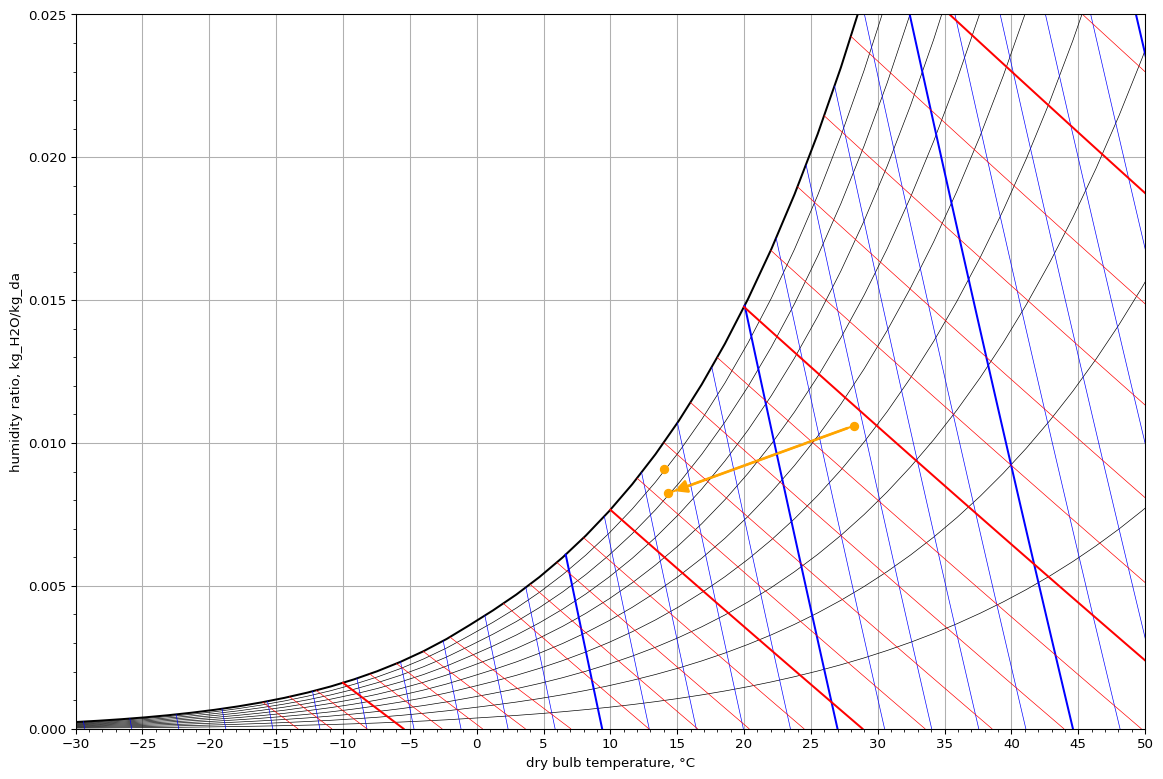

In [25]:
psy_chart = PsychrometricChart()
psy_chart.plot_process(
    name='cooling coil',
    start_point=start,
    end_point=end
)
psy_chart.plot_point(
    name='target',
    point=target
)
psy_chart.show()